In [149]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy.misc import comb
from sklearn.model_selection import train_test_split , KFold, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import pdb
from sklearn.metrics import roc_auc_score , make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import NuestroArbol as ourTree
import random
from scipy.stats import randint as sp_randint
from time import time
import collections

%matplotlib inline

## Cargar datos 

In [19]:
X_comp = pd.read_csv('X_competencia.csv')
X = pd.read_csv('X.csv',index_col="index")
y = pd.read_csv('y.csv',index_col="index")
#X.drop(['index'],inplace=True, axis=1)
#y.drop(['index'], inplace=True,axis=1)



In [20]:
#partimos los datos en desarrollo(87%) y holdout(13%). 
X_desarrollo , X_holout ,y_desarrollo, y_holdout = train_test_split(X, y['output'],
                                                                    test_size=0.13,random_state=0,stratify=y['output'])
#pase los kfold aca arriba ya que se usan en varios lugares.
#evaluar si esta bueno que siempre se usen los mismos folds
kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)


5

# Ejercicio 4

### Diagnóstico Sesgo-Varianza. 

En este punto, se pide inspeccionar dos de sus mejores modelos encontrados hasta ahora: el mejor modelo de tipo árbol de decisión y el mejor de tipo SVM. Para ello:

1. Graficar curvas de complejidad para cada modelo, variando la profundidad en el caso de árboles, y el hiperparámetro C en el caso de SVM. Diagnosticar cómo afectan al sesgo y a la varianza esos dos hiperparámetros.
2. Graficar curvas de aprendizaje para cada modelo. En base a estas curvas, sacar conclusiones sobre si los algoritmos parecen haber alcanzado su límite, o bien si aumentar la cantidad de datos debería ayudar.
3. Construir un modelo RandomForest con 200 árboles. Explorar para qué sirve el hiperparámetro max_features y cómo afecta a la performance del algoritmo mediante una curva de complejidad. Explicar por qué creen que se dieron los resultados obtenidos. Por último, graficar una curva de aprendizaje sobre los parámetros elegidos para determinar si sería útil o no conseguir más datos (usar  grid search para encontrar una buena combinación de parámetros).  


**Atención**: Tener en cuenta que debemos seguir utilizando ROC AUC como métrica para estas curvas.

**ver**: http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve

----
**EJERCICIO EXTRA:** Utilizar RandomizedSearchCV para explorar la performance del algoritmo de Gradient Boosting y comparar con los resultados obtenidos en el punto (c).


----



# 4.1

In [ ]:
roc_auc_score = make_scorer(roc_auc_score)

In [21]:
kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

5

### Arboles

In [81]:
Depths=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

dic={}
for d in Depths:
    #print(c)
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

        model=DecisionTreeClassifier(max_depth=d)
        model.fit(X_train,y_train)

        #print(roc_auc_score(y_train,model.predict(X_train)),roc_auc_score(y_val,model.predict(X_val)))
        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[d]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(Depths);

,train_score_err,train_score_mean,val_score_err,val_score_mean
1,0.005866,0.714162,0.025802,0.664296
2,0.018133,0.726489,0.025496,0.639004
3,0.019006,0.814548,0.055542,0.641982
4,0.022052,0.874007,0.043433,0.661692
5,0.008896,0.925565,0.053284,0.672304
6,0.014444,0.964280,0.060145,0.654626
7,0.005260,0.988856,0.047530,0.672587
8,0.003465,0.997592,0.039352,0.668662
9,0.002500,0.998750,0.050473,0.663946
10,0.000000,1.000000,0.049284,0.664666


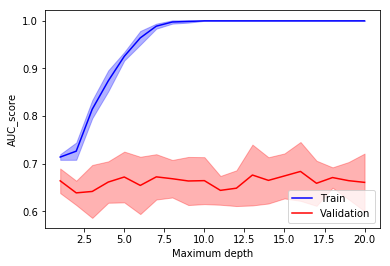

In [82]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Maximum depth")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

### SVC

In [79]:
# Tomo el mejor gamma y el mejor kernel encontrado mediante RandomSearch/GridSearch

#Cs=[0.01,0.1,1,10,100,1000]
Cs=[1,2.5,5,10,25,50,100]
#Cs=[5,6,7,8,9,10,11,12,13,14,15]

dic={}
for c in Cs:
    #print(c)
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test  in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

        model=SVC(C=c,kernel="rbf",gamma=0.0001)
        model.fit(X_train,y_train)

        #print(roc_auc_score(y_train,model.predict(X_train)),roc_auc_score(y_val,model.predict(X_val)))
        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(Cs)

,train_score_err,train_score_mean,val_score_err,val_score_mean
1.0,0.011180,0.738827,0.029850,0.719352
2.5,0.015781,0.784775,0.028277,0.719491
5.0,0.005434,0.822168,0.033032,0.740820
10.0,0.004707,0.854120,0.042698,0.752243
25.0,0.005048,0.889977,0.058086,0.732265
50.0,0.006552,0.915037,0.061732,0.709495
100.0,0.007978,0.934348,0.062711,0.698637


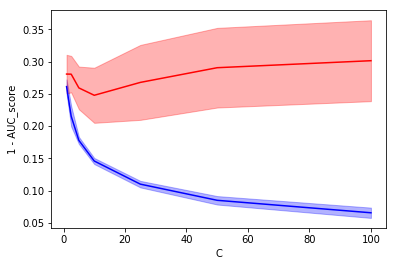

In [80]:
plt.plot(df.index,1-df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, 1-(df.train_score_mean - df.train_score_err),
                 1-(df.train_score_mean + df.train_score_err), alpha=0.3,color="b")

plt.plot(df.index,1-df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, 1-(df.val_score_mean - df.val_score_err),
                 1-(df.val_score_mean + df.val_score_err), alpha=0.3,color="r")

plt.xlabel("C")
plt.ylabel("1 - AUC_score")
plt.legend()
plt.show()

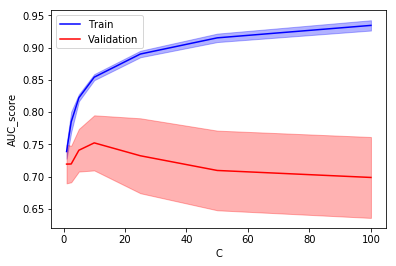

In [61]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("C")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

# 4.2

In [91]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring='roc_auc'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.3, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Árboles

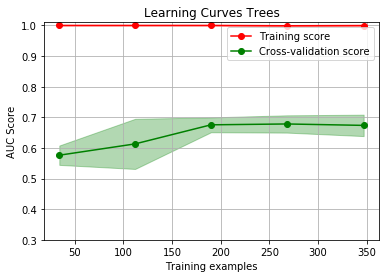

In [168]:
title = "Learning Curves Trees"

kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

estimator = DecisionTreeClassifier(max_depth=10)
plot_learning_curve(estimator, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()

### SVC

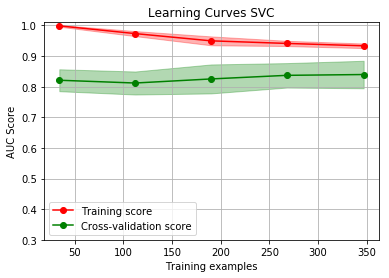

In [167]:
title = "Learning Curves SVC"

kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

estimator = SVC(C=10,kernel="rbf",gamma=0.0001)
plot_learning_curve(estimator, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()

## 4.3

In [159]:
kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

param_grid = {'max_features': ['sqrt', 'log2']+range(0,201,20)[1:],
              'max_depth' : range(4,20),
              'criterion' :['gini', 'entropy']}

model=RandomForestClassifier(n_estimators=200,random_state=42,n_jobs=-1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, scoring='roc_auc',n_jobs=-1)
grid.fit(X_desarrollo, y_desarrollo);
print("end")

end


In [160]:
model=grid.best_estimator_
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=11, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [161]:
kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

Mxfs=range(0,20)[1:]

dic={}
for c in Mxfs:
    ROC_AUC_train=[]
    ROC_AUC_val=[]
    
    for train, test in kfold.split(X_desarrollo,y_desarrollo):
        X_train, X_val = X_desarrollo.iloc[train], X_desarrollo.iloc[test]
        y_train, y_val = y_desarrollo.iloc[train], y_desarrollo.iloc[test]

        #model=RandomForestClassifier(n_estimators=200,max_features=c)
        model=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=c, 
                                     max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, 
                                     n_jobs=-1,oob_score=False,random_state=42,verbose=0, warm_start=False)
        model.fit(X_train,y_train)

        #print(roc_auc_score(y_train,model.predict(X_train)),roc_auc_score(y_val,model.predict(X_val)))
        ROC_AUC_train.append(roc_auc_score(y_train,model.predict(X_train)))
        ROC_AUC_val.append(roc_auc_score(y_val,model.predict(X_val)))
        
    tsm=np.mean(ROC_AUC_train)
    tse=np.std(ROC_AUC_train)
    vsm=np.mean(ROC_AUC_val)
    vse=np.std(ROC_AUC_val)
    
    dic[c]={"train_score_mean":tsm,"train_score_err":tse,"val_score_mean":vsm,"val_score_err":vse}

df=pd.DataFrame(dic).T
df.reindex(Mxfs);

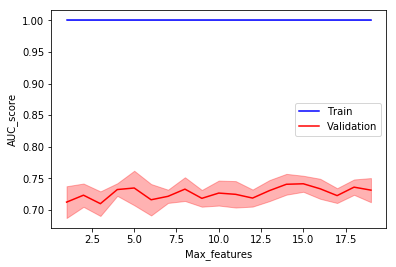

In [162]:
plt.plot(df.index,df.train_score_mean,color="b",label="Train")
plt.fill_between(df.index, df.train_score_mean - df.train_score_err,
                 df.train_score_mean + df.train_score_err, alpha=0.3,color="b")

plt.plot(df.index,df.val_score_mean,color="r",label="Validation")
plt.fill_between(df.index, df.val_score_mean - df.val_score_err,
                 df.val_score_mean + df.val_score_err, alpha=0.3,color="r")

plt.xlabel("Max_features")
plt.ylabel("AUC_score")
plt.legend()
plt.show()

In [164]:
df

,train_score_err,train_score_mean,val_score_err,val_score_mean
1,0.0,1.0,0.025129,0.712319
2,0.0,1.0,0.018430,0.723301
3,0.0,1.0,0.019437,0.709879
4,0.0,1.0,0.009975,0.732228
5,0.0,1.0,0.027278,0.734684
6,0.0,1.0,0.024867,0.716065
7,0.0,1.0,0.010460,0.721521
8,0.0,1.0,0.018763,0.732904
9,0.0,1.0,0.013229,0.718325
10,0.0,1.0,0.019763,0.726654


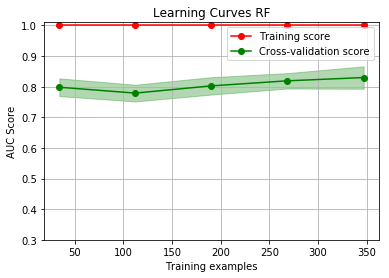

In [166]:
title = "Learning Curves RF"

kfold = StratifiedKFold(n_splits=5)
kfold.get_n_splits(X_desarrollo,y_desarrollo)

estimator = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=11,max_features=15, 
                                     max_leaf_nodes=None,min_impurity_decrease=0.0,min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,min_weight_fraction_leaf=0.0,n_estimators=200, 
                                     n_jobs=-1,oob_score=False,random_state=42,verbose=0, warm_start=False)

plot_learning_curve(estimator, title, X_desarrollo, y_desarrollo, ylim=(0.3, 1.01), cv=kfold, n_jobs=-1)

plt.show()